In [279]:
import gym
from hiive.mdptoolbox.example import forest
from hiive.mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import itertools
import pickle
import pdb
from copy import deepcopy
%matplotlib inline

np.random.seed(1234)
pd.options.mode.chained_assignment = None

In [372]:
def envPlot(N, title, policy, actions, colorBG, colorSelect, actionTextSize):
    '''
    Plots the policy on the environment
    N - leg length of the environment size. envionment state space is N^2
    title - title in plot
    policy - N x N numpy array to give the action enum for each state 
    actions - maps action enum to action letter to show on plot
    colorBG - maps some key to background color of state plot cell
    colorSelect - yields key to colorBG for an environment state
    actionTextSize - size of plot 
    '''
    fig = plt.figure(figsize=(N, N))
    plt.title(title)
    
    ax = fig.add_subplot(111, xlim=(-.01, N+0.01), ylim=(-.01, N+0.01))

    for i in range(N):
        for j in range(N):
            YLoc = N - i - 1  
            XLoc = j
            pos = plt.Rectangle([XLoc, YLoc], 1, 1, linewidth=1, edgecolor='k')
            pos.set_facecolor(colorBG[colorSelect[i, j]])
            ax.add_patch(pos)
            ax.text(XLoc + 0.5, 
                    YLoc + 0.5,
                    actions[policy[i, j]], 
                    size=actionTextSize)    
    plt.axis('off')
    
# only for frozen lake
def getTandRfromP(gymEnv, numActions):
    rows = env.nrow
    cols = env.ncol
    T = np.zeros((numActions, rows*cols, rows*cols))
    R = np.zeros((numActions, rows*cols, rows*cols))
    P = gymEnv.P
    
    oldState = np.inf
    
    for state in P:
        for action in P[state]:
            for (prob, newState, reward, isDone) in P[state][action]:
                if newState == oldState:
                    T[action][state][newState] += prob
                    R[action][state][newState] += reward
                else:
                    T[action][state][newState] = prob
                    R[action][state][newState] = reward
                oldState = newState
    
    return T, R

# only for frozenn lake - run using given policy
def evaluate_policy_FL(gymEnv, policy, numEps=1000):
    #Policy = policy.flatten()
    Policy = policy
    # total number of failures across all episodes
    failures = 0
    # array of the step counter when reached the successful end
    end_steps = []
    for episode in range(numEps):
        observation, info = env.reset()
        step = 0
        while True:
            action = Policy[observation]
            observation, reward, terminated, truncated, info = env.step(action)
            step += 1
            # reached the end
            if (terminated or truncated) and reward == 1:
                end_steps.append(step)
                break
            # fell into a hole
            elif (terminated or truncated) and reward == 0:
                failures += 1
                break
                
    success_rate = 1 - (failures/numEps)
    if len(end_steps) != 0:
        avg_steps_success = np.mean(end_steps)
    else:
        avg_steps_success = -1
    
    return avg_steps_success, success_rate

# only for frozen lake
def wrapper_evaluate_FL(gymEnv, results):
    for i in results:
        avg_steps_success, success_rate = evaluate_policy_FL(gymEnv, results[i]['policy'])
        results[i]['avg_steps_success'] = avg_steps_success
        results[i]['success_rate'] = success_rate

# returns a list of dicts for each hyperparameter combination
# ie, hyper_names=['a', 'b'] and hyper_list=[[1], [4, 5]] returns [{'a':1, 'b':4}, {'a':1, 'b':5}
def helperIterateHyperParams(hyper_names, hyper_list):
    unnamed_combos = list(itertools.product(*hyper_list))
    list_of_dicts = []
    for combo in unnamed_combos:
        subDict = {}
        for i in range(len(hyper_names)):
            hyper_name = hyper_names[i]
            subDict[hyper_name] = combo[i]
        list_of_dicts.append(subDict)
    
    return list_of_dicts

def RL_routine(T, R, hyperparams, algorithm, verbose=False):
    results = {}
    i = 0
    for hyper in hyperparams:
        if verbose:
            print("param combo " + str(i + 1) + "/" + str(len(hyperparams)))
        results[i] = {}
        results[i]['hyperparameters'] = hyper
        
        alg_inst = algorithm(T, R, **hyper)
        testRuns = alg_inst.run()
        
        results[i]['Time'] = testRuns[-1]['Time']
        results[i]['Iteration'] = testRuns[-1]['Iteration']
        results[i]['Reward'] = testRuns[-1]['Max V']
        
        results[i]['policy'] = alg_inst.policy

        i += 1
            
    return results

def RL_routine_results_to_DF(results, FL=False):
    columns = []
    for name in results[0]['hyperparameters']:
        columns.append(name)
    columns.append('Time')
    columns.append('Iteration')
    columns.append('Reward')
    if FL:
        columns.append('avg_steps_success')
        columns.append('success_rate')
        
    df = pd.DataFrame(0, index=list(results.keys()), columns=columns)
    
    for i in sorted(results.keys()):
        for name in results[i]['hyperparameters']:
            df[name][i] = results[i]['hyperparameters'][name]
        df['Time'][i] = results[i]['Time']
        df['Iteration'][i] = results[i]['Iteration']
        df['Reward'][i] = results[i]['Reward']
        if FL:
            df['avg_steps_success'][i] = results[i]['avg_steps_success']
            df['success_rate'][i] = results[i]['success_rate']
            
    return df

def plotMeans(df, xLab, yLab, title):
    X = sorted(list(set(df[xLab])))
    Y = []
    for xVal in X:
        Y.append((df[df[xLab] == xVal][yLab]).mean())
    plt.figure()
    plt.plot(X, Y)
    plt.title(title)
    plt.xlabel(xLab)
    plt.ylabel(yLab)
    plt.grid()

In [355]:
df2 = deepcopy(VI_FL_results_df)

In [364]:
df2[df2['gamma'] == 0.1]['success_rate']

0    0.000
1    0.000
2    0.227
3    0.453
4    0.460
5    0.448
Name: success_rate, dtype: float64

# frozen lake

In [214]:
env = gym.make('FrozenLake-v1').unwrapped
T_fl, R_fl = getTandRfromP(env, 4)

In [215]:
FL_actions = {
            0: 'L',
            1: 'D',
            2: 'R',
            3: 'U'
}

FL_colorBG = {
    b'S': 'y',
    b'F': 'w',
    b'H': 'k',
    b'G': 'g'
}

## Value iteration - VI
epsilon is the stopping condition, gamma is the discount factor

In [216]:
VI_hyperNames = ["gamma", "epsilon"]
VI_hyperList = [
    [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    [1e-2, 1e-4, 1e-6, 1e-8, 1e-10, 1e-12]
]
VI_hyperparams = helperIterateHyperParams(VI_hyperNames, VI_hyperList)
VI_FL_results = RL_routine(T_fl, R_fl, VI_hyperparams, ValueIteration)

In [307]:
wrapper_evaluate_FL(env, VI_FL_results)
VI_FL_results_df = RL_routine_results_to_DF(VI_FL_results, True)

##### VI resultss - df

In [308]:
VI_FL_results_df

,gamma,epsilon,Time,Iteration,Reward,avg_steps_success,success_rate
0,0.1,1.000000e-02,0.000049,1,0.333333,-1.000000,0.000
1,0.1,1.000000e-04,0.000189,3,0.345185,-1.000000,0.000
2,0.1,1.000000e-06,0.000237,5,0.345239,19.290749,0.227
3,0.1,1.000000e-08,0.000383,7,0.345239,27.876380,0.453
4,0.1,1.000000e-10,0.000398,9,0.345239,29.750000,0.460
5,0.1,1.000000e-12,0.000524,11,0.345239,29.185268,0.448
6,0.2,1.000000e-02,0.000075,2,0.355556,-1.000000,0.000
7,0.2,1.000000e-04,0.000214,5,0.358979,19.225532,0.235
8,0.2,1.000000e-06,0.000351,7,0.358991,30.324943,0.437
9,0.2,1.000000e-08,0.000437,10,0.358992,29.389868,0.454


In [347]:
VI_FL_results_df['Time'].mean()

0.0018637047873602973

#### VI policy plot

In [388]:
VI_FL_policy = np.array(VI_FL_results[VI_FL_results_df['Reward'].argmax()]['policy']).reshape((4, 4))
VI_FL_policy

array([[0, 3, 0, 3],
       [0, 0, 0, 0],
       [3, 1, 0, 0],
       [0, 2, 1, 0]])

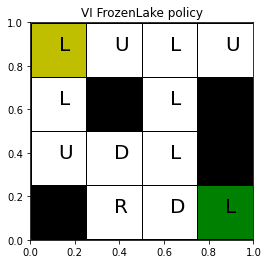

In [220]:
envPlot(4, "VI FrozenLake policy", VI_FL_policy, FL_actions,
        FL_colorBG, env.desc, 20)

### VI plots

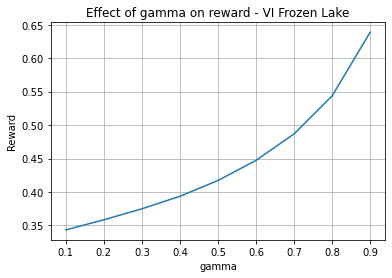

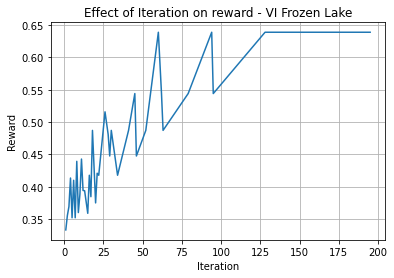

In [373]:
plotMeans(VI_FL_results_df, "gamma", "Reward", 
          "Effect of gamma on reward - VI Frozen Lake")
plotMeans(VI_FL_results_df, "Iteration", "Reward", 
          "Effect of Iteration on reward - VI Frozen Lake")

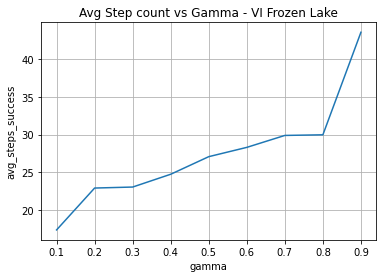

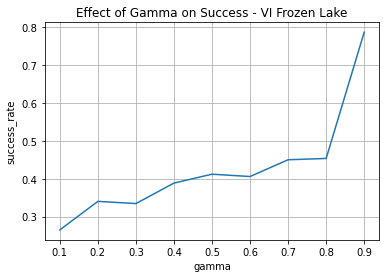

In [374]:
plotMeans(VI_FL_results_df, "gamma", "avg_steps_success", 
          "Avg Step count vs Gamma - VI Frozen Lake")
plotMeans(VI_FL_results_df, "gamma", "success_rate", 
          "Effect of Gamma on Success - VI Frozen Lake")

<AxesSubplot:title={'center':'Effect of Gamma on Success - VI Frozen Lake'}, xlabel='gamma', ylabel='success_rate'>

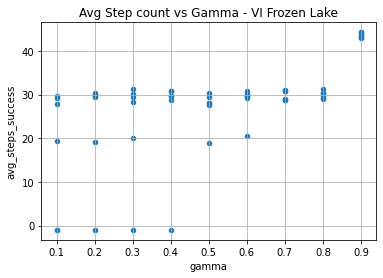

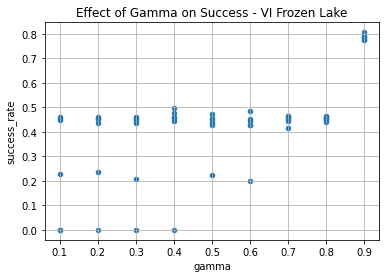

In [333]:


VI_FL_results_df.plot(x="gamma", y="avg_steps_success", 
                      kind='scatter', title="Avg Step count vs Gamma - VI Frozen Lake", grid=True)

VI_FL_results_df.plot(x="gamma", y="success_rate", kind='scatter', 
                      title="Effect of Gamma on Success - VI Frozen Lake", grid=True)

## Policy Iteration - PI

In [222]:
PI_hyperNames = ["gamma"]
PI_hyperList = [
    [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
]
PI_hyperparams = helperIterateHyperParams(PI_hyperNames, PI_hyperList)
PI_FL_results = RL_routine(T_fl, R_fl, PI_hyperparams, PolicyIteration)

In [325]:
%%time
wrapper_evaluate_FL(env, PI_FL_results)
PI_FL_results_df = RL_routine_results_to_DF(PI_FL_results, True)

CPU times: user 2.37 s, sys: 30.2 ms, total: 2.4 s
Wall time: 2.38 s


##### PI - df

In [326]:
PI_FL_results_df

,gamma,Time,Iteration,Reward,avg_steps_success,success_rate
0,0.1,0.003253,4,0.345239,29.197339,0.451
1,0.2,0.001234,4,0.358992,27.931183,0.465
2,0.3,0.001251,4,0.375103,29.638950,0.457
3,0.4,0.001442,4,0.394332,29.251670,0.449
4,0.5,0.001321,4,0.417861,29.745303,0.479
5,0.6,0.001827,4,0.447649,28.248879,0.446
6,0.7,0.001476,4,0.487267,28.222944,0.462
7,0.8,0.000954,3,0.544196,28.242826,0.453
8,0.9,0.001590,5,0.639020,45.546164,0.769


In [346]:
PI_FL_results_df['Time'].mean()

0.0015941725836859809

#### PI - policy plot

In [223]:
PI_FL_policy = np.array(PI_FL_results[PI_FL_results_df['Reward'].argmax()]['policy']).reshape((4, 4))
PI_FL_policy

array([[0, 3, 0, 3],
       [0, 0, 0, 0],
       [3, 1, 0, 0],
       [0, 2, 1, 0]])

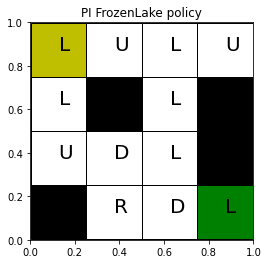

In [224]:
envPlot(4, "PI FrozenLake policy", PI_FL_policy, FL_actions,
        FL_colorBG, env.desc, 20)

#### PI plots

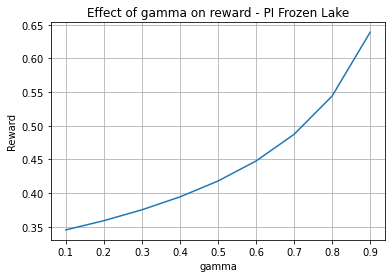

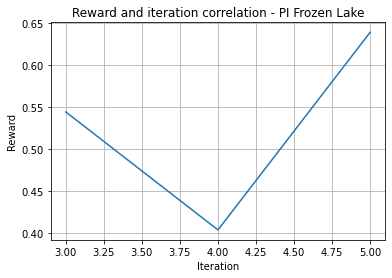

In [375]:
plotMeans(PI_FL_results_df, "gamma", "Reward", 
          "Effect of gamma on reward - PI Frozen Lake")
plotMeans(PI_FL_results_df, "Iteration", "Reward", 
          "Reward and iteration correlation - PI Frozen Lake")

<AxesSubplot:title={'center':'Reward and iteration correlation - PI Frozen Lake'}, xlabel='Iteration', ylabel='Reward'>

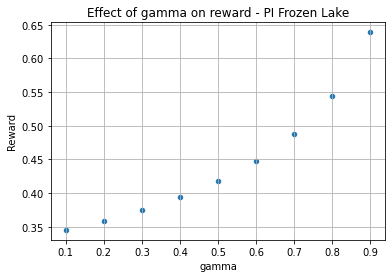

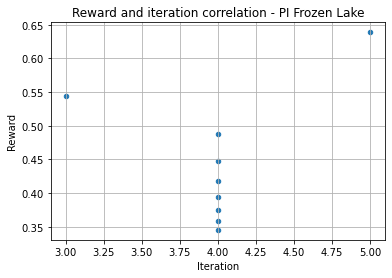

In [349]:
PI_FL_results_df.plot(x="gamma", y="Reward", 
                      title="Effect of gamma on reward - PI Frozen Lake",
                     kind="scatter", grid=True)

PI_FL_results_df.plot(x="Iteration", y="Reward", 
                      title="Reward and iteration correlation - PI Frozen Lake",
                     kind="scatter", grid=True)

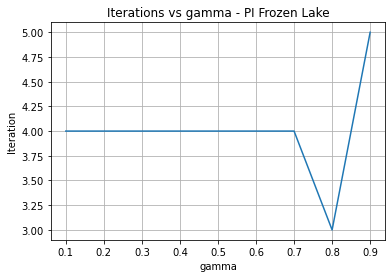

In [376]:
plotMeans(PI_FL_results_df, "gamma", "Iteration", 
          "Iterations vs gamma - PI Frozen Lake")

<AxesSubplot:title={'center':'Iterations vs gamma - PI Frozen Lake'}, xlabel='gamma', ylabel='Iteration'>

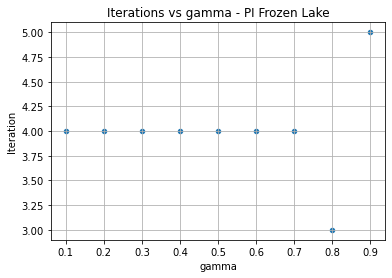

In [330]:
PI_FL_results_df.plot(x="gamma", y="Iteration", kind='scatter', 
                      title="Iterations vs gamma - PI Frozen Lake", grid=True)

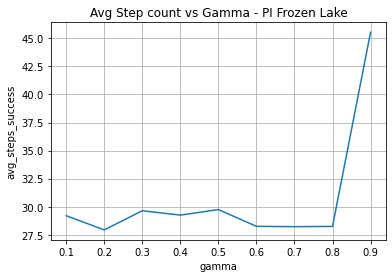

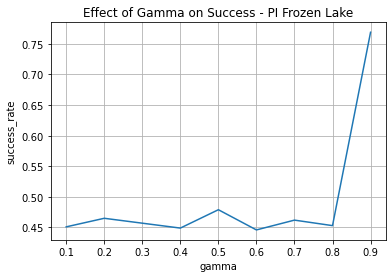

In [377]:
plotMeans(PI_FL_results_df, "gamma", "avg_steps_success", 
          "Avg Step count vs Gamma - PI Frozen Lake")
plotMeans(PI_FL_results_df, "gamma", "success_rate", 
          "Effect of Gamma on Success - PI Frozen Lake")

<AxesSubplot:title={'center':'Effect of Gamma on Success - PI Frozen Lake'}, xlabel='gamma', ylabel='success_rate'>

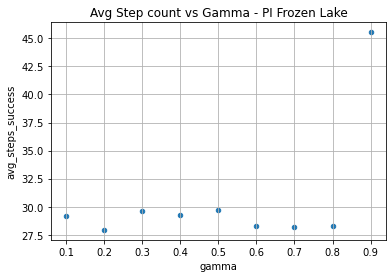

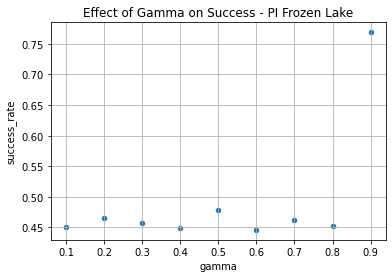

In [332]:
PI_FL_results_df.plot(x="gamma", y="avg_steps_success", 
                      kind='scatter', title="Avg Step count vs Gamma - PI Frozen Lake", grid=True)

PI_FL_results_df.plot(x="gamma", y="success_rate", kind='scatter', 
                      title="Effect of Gamma on Success - PI Frozen Lake", grid=True)

## Q-learning

In [259]:
%%time
QL_hyperNames = ["gamma", "alpha", "alpha_decay", "epsilon_decay", "n_iter"]
QL_hyperList = [
    [0.9, 0.99],
    [0.1, 0.2],
    [0.9, 0.99],
    [0.9, 0.99],
    [1000000, 10000000]
]

QL_hyperparams = helperIterateHyperParams(QL_hyperNames, QL_hyperList)
QL_FL_results = RL_routine(T_fl, R_fl, QL_hyperparams, QLearning, verbose=True)

param combo 1/32
param combo 2/32
param combo 3/32
param combo 4/32
param combo 5/32
param combo 6/32
param combo 7/32
param combo 8/32
param combo 9/32
param combo 10/32
param combo 11/32
param combo 12/32
param combo 13/32
param combo 14/32
param combo 15/32
param combo 16/32
param combo 17/32
param combo 18/32
param combo 19/32
param combo 20/32
param combo 21/32
param combo 22/32
param combo 23/32
param combo 24/32
param combo 25/32
param combo 26/32
param combo 27/32
param combo 28/32
param combo 29/32
param combo 30/32
param combo 31/32
param combo 32/32
CPU times: user 1h 38min 48s, sys: 1min 12s, total: 1h 40min 1s
Wall time: 1h 39min 55s


In [335]:
%%time
wrapper_evaluate_FL(env, QL_FL_results)
QL_FL_results_df = RL_routine_results_to_DF(QL_FL_results, True)

CPU times: user 4.33 s, sys: 121 µs, total: 4.33 s
Wall time: 4.31 s


In [336]:
with open('QL_FL_results.pickle', 'wb') as handle:
    pickle.dump(QL_FL_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

### QL results DF

In [337]:
QL_FL_results_df

,gamma,alpha,alpha_decay,epsilon_decay,n_iter,Time,Iteration,Reward,avg_steps_success,success_rate
0,0.90,0.1,0.90,0.90,1000000,34.429751,1000000,0.370404,17.180328,0.061
1,0.90,0.1,0.90,0.90,10000000,342.570267,10000000,0.565387,14.101695,0.059
2,0.90,0.1,0.90,0.99,1000000,34.816298,1000000,0.442137,15.393939,0.066
3,0.90,0.1,0.90,0.99,10000000,343.983541,10000000,0.637647,20.080000,0.225
4,0.90,0.1,0.99,0.90,1000000,33.869360,1000000,0.400036,12.142857,0.035
5,0.90,0.1,0.99,0.90,10000000,342.283967,10000000,0.606080,15.295238,0.105
6,0.90,0.1,0.99,0.99,1000000,33.772150,1000000,0.320843,17.117647,0.034
7,0.90,0.1,0.99,0.99,10000000,345.271434,10000000,0.572011,16.661538,0.065
8,0.90,0.2,0.90,0.90,1000000,34.864731,1000000,0.395566,25.912088,0.182
9,0.90,0.2,0.90,0.90,10000000,342.874781,10000000,0.486381,20.528169,0.142


In [345]:
QL_FL_results_df['Time'].mean()

187.34419666230679

### plot QL policy for FL

In [391]:
QL_FL_policy = np.array(QL_FL_results[QL_FL_results_df['Reward'].argmax()]['policy']).reshape((4, 4))
QL_FL_policy

array([[2, 3, 0, 1],
       [0, 0, 0, 0],
       [1, 1, 0, 0],
       [0, 2, 1, 0]])

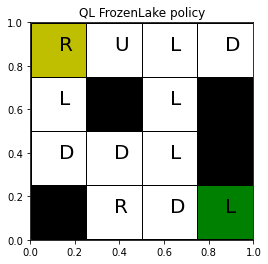

In [392]:
envPlot(4, "QL FrozenLake policy", QL_FL_policy, FL_actions,
        FL_colorBG, env.desc, 20)

In [393]:
QL_FL_policy = np.array(QL_FL_results[QL_FL_results_df['success_rate'].argmax()]['policy']).reshape((4, 4))
QL_FL_policy

array([[0, 2, 0, 1],
       [0, 0, 0, 0],
       [3, 1, 1, 0],
       [0, 2, 1, 0]])

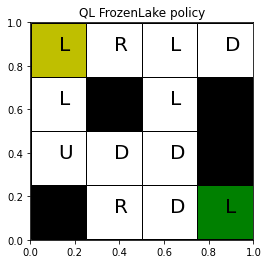

In [394]:
envPlot(4, "QL FrozenLake policy", QL_FL_policy, FL_actions,
        FL_colorBG, env.desc, 20)

### plots

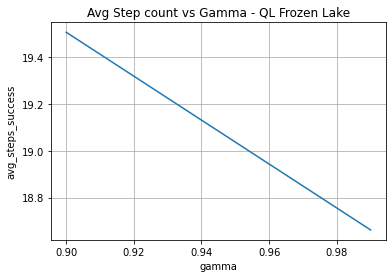

In [378]:
plotMeans(QL_FL_results_df, "gamma", "avg_steps_success", 
          "Avg Step count vs Gamma - QL Frozen Lake")

<AxesSubplot:title={'center':'Avg Step count vs Gamma - QL Frozen Lake'}, xlabel='gamma', ylabel='avg_steps_success'>

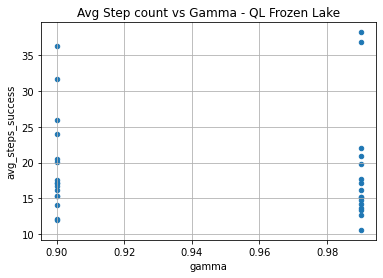

In [379]:
QL_FL_results_df.plot(x="gamma", y="avg_steps_success", 
                      kind='scatter', title="Avg Step count vs Gamma - QL Frozen Lake", grid=True)

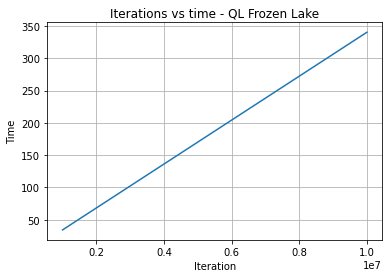

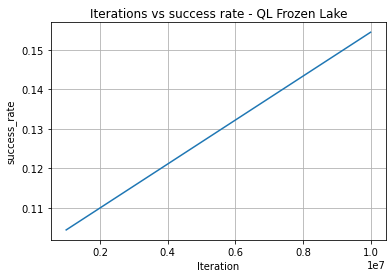

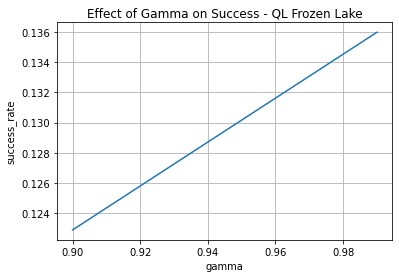

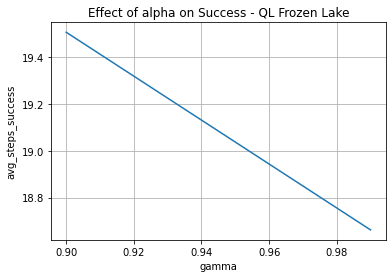

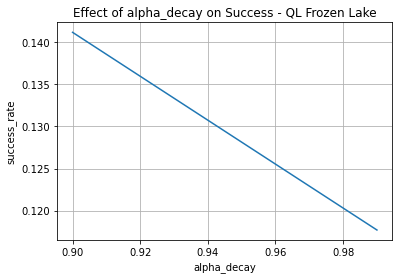

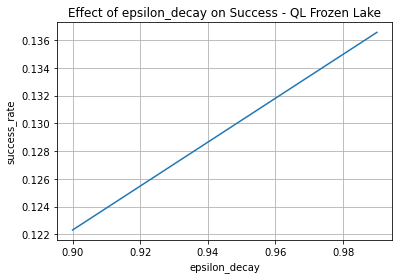

In [380]:
plotMeans(QL_FL_results_df, "Iteration", "Time", 
          "Iterations vs time - QL Frozen Lake")
plotMeans(QL_FL_results_df, "Iteration", "success_rate", 
          "Iterations vs success rate - QL Frozen Lake")
plotMeans(QL_FL_results_df, "gamma", "success_rate", 
          "Effect of Gamma on Success - QL Frozen Lake")
plotMeans(QL_FL_results_df, "gamma", "avg_steps_success", 
          "Effect of alpha on Success - QL Frozen Lake")
plotMeans(QL_FL_results_df, "alpha_decay", "success_rate", 
          "Effect of alpha_decay on Success - QL Frozen Lake")
plotMeans(QL_FL_results_df, "epsilon_decay", "success_rate", 
          "Effect of epsilon_decay on Success - QL Frozen Lake")

<AxesSubplot:title={'center':'Effect of epsilon_decay on Success - QL Frozen Lake'}, xlabel='epsilon_decay', ylabel='success_rate'>

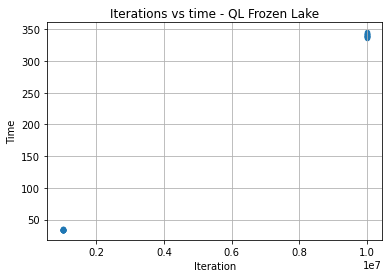

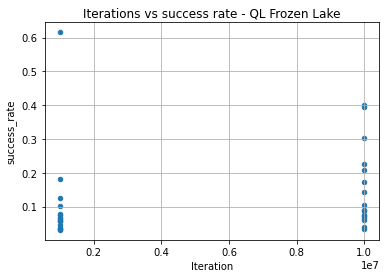

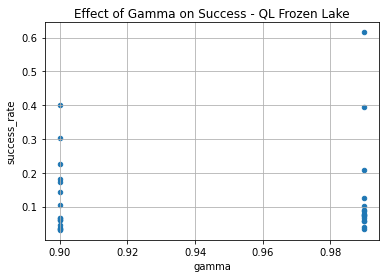

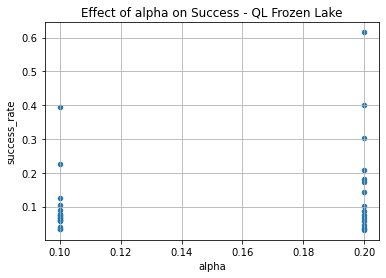

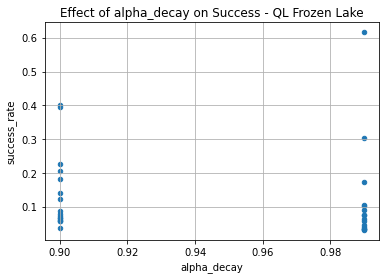

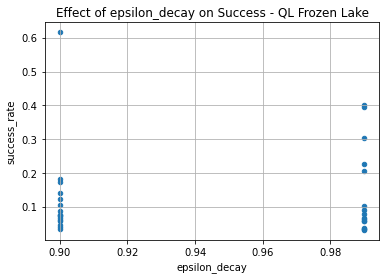

In [340]:
QL_FL_results_df.plot(x="Iteration", y="Time", 
                      kind='scatter', title="Iterations vs time - QL Frozen Lake", grid=True)

QL_FL_results_df.plot(x="Iteration", y="success_rate", kind='scatter', 
                      title="Iterations vs success rate - QL Frozen Lake", grid=True)

QL_FL_results_df.plot(x="gamma", y="success_rate", kind='scatter', 
                      title="Effect of Gamma on Success - QL Frozen Lake", grid=True)
QL_FL_results_df.plot(x="alpha", y="success_rate", kind='scatter', 
                      title="Effect of alpha on Success - QL Frozen Lake", grid=True)
QL_FL_results_df.plot(x="alpha_decay", y="success_rate", kind='scatter', 
                      title="Effect of alpha_decay on Success - QL Frozen Lake", grid=True)
QL_FL_results_df.plot(x="epsilon_decay", y="success_rate", kind='scatter', 
                      title="Effect of epsilon_decay on Success - QL Frozen Lake", grid=True)

# Forest Management

In [225]:
T_fm, R_fm = forest(S=225)

In [226]:
FM_actions = {
        0: 'W',
        1: 'C',
}

FM_colorBG = {
    0: 'w',
    1: 'g',
}

## Value iteration VI

In [227]:
VI_hyperNames = ["gamma", "epsilon"]
VI_hyperList = [
    [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    [1e-2, 1e-4, 1e-6, 1e-8, 1e-10, 1e-12]
]
VI_hyperparams = helperIterateHyperParams(VI_hyperNames, VI_hyperList)
VI_FM_results = RL_routine(T_fm, R_fm, VI_hyperparams, ValueIteration)
VI_FM_results_df = RL_routine_results_to_DF(VI_FM_results)

#### VI  FM results df

In [228]:
VI_FM_results_df

,gamma,epsilon,Time,Iteration,Reward
0,0.1,1.000000e-02,0.002699,2,4.360000
1,0.1,1.000000e-04,0.001050,4,4.396306
2,0.1,1.000000e-06,0.001199,6,4.396610
3,0.1,1.000000e-08,0.006380,8,4.396613
4,0.1,1.000000e-10,0.013144,10,4.396613
5,0.1,1.000000e-12,0.000729,12,4.396613
6,0.2,1.000000e-02,0.000163,3,4.853200
7,0.2,1.000000e-04,0.008291,6,4.882516
8,0.2,1.000000e-06,0.000550,9,4.882698
9,0.2,1.000000e-08,0.002821,11,4.882699


In [342]:
VI_FM_results_df['Time'].mean()

0.004003476213525843

#### plot VI policy

In [229]:
VI_FM_policy = np.array(VI_FM_results[VI_FM_results_df['Reward'].argmax()]['policy']).reshape((15, 15))
VI_FM_policy

array([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

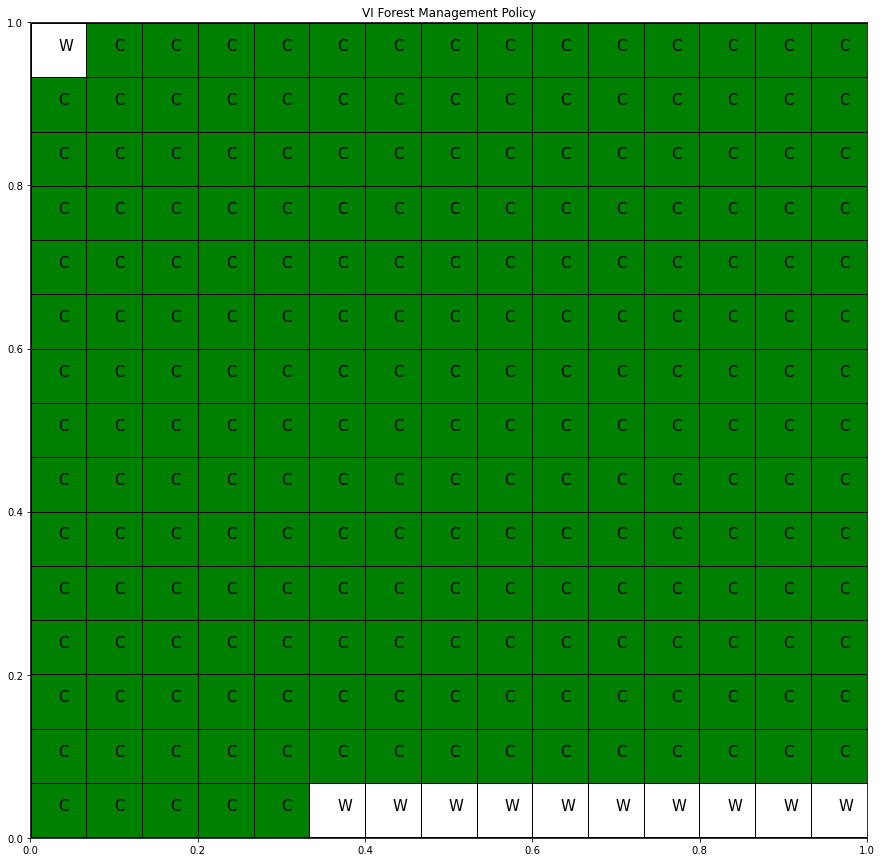

In [230]:
envPlot(15, "VI Forest Management Policy", VI_FM_policy, FM_actions, FM_colorBG, 
        VI_FM_policy, 15)

In [ ]:
VI_FM_results_df

### plots

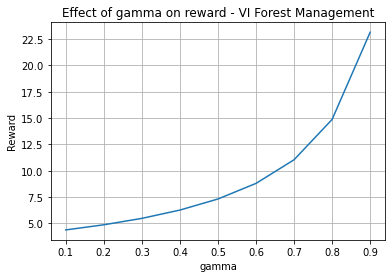

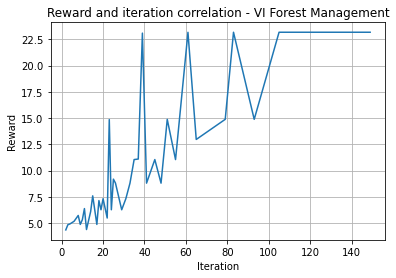

In [381]:
plotMeans(VI_FM_results_df, "gamma", "Reward", 
          "Effect of gamma on reward - VI Forest Management")
plotMeans(VI_FM_results_df, "Iteration", "Reward", 
          "Reward and iteration correlation - VI Forest Management")

<AxesSubplot:title={'center':'Reward and iteration correlation - VI Forest Management'}, xlabel='Iteration', ylabel='Reward'>

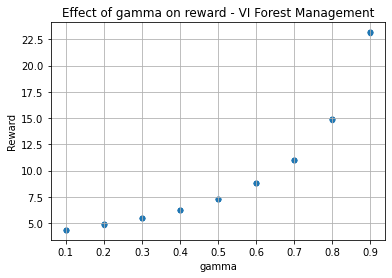

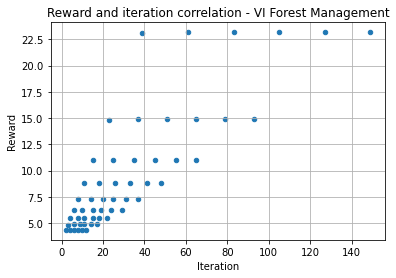

In [351]:
VI_FM_results_df.plot(x="gamma", y="Reward", 
                      title="Effect of gamma on reward - VI Forest Management",
                     kind="scatter", grid=True)

VI_FM_results_df.plot(x="Iteration", y="Reward", 
                      title="Reward and iteration correlation - VI Forest Management",
                     kind="scatter", grid=True)

## Policy Iteration PI

In [231]:
PI_hyperNames = ["gamma"]
PI_hyperList = [
    [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
]
PI_hyperparams = helperIterateHyperParams(PI_hyperNames, PI_hyperList)
PI_FM_results = RL_routine(T_fm, R_fm, PI_hyperparams, PolicyIteration)
PI_FM_results_df = RL_routine_results_to_DF(PI_FM_results)

#### PI FM results df

In [232]:
PI_FM_results_df

,gamma,Time,Iteration,Reward
0,0.1,0.001121,1,4.396613
1,0.2,0.001020,1,4.882699
2,0.3,0.002524,2,5.491933
3,0.4,0.003307,2,6.277574
4,0.5,0.003123,3,7.329154
5,0.6,0.002995,3,8.809994
6,0.7,0.047243,5,11.054551
7,0.8,0.006252,6,14.883721
8,0.9,0.008922,10,23.172434


In [343]:
PI_FM_results_df['Time'].mean()

0.00850073496500651

#### plot PI policy

In [233]:
PI_FM_policy = np.array(PI_FM_results[PI_FM_results_df['Reward'].argmax()]['policy']).reshape((15, 15))
PI_FM_policy

array([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

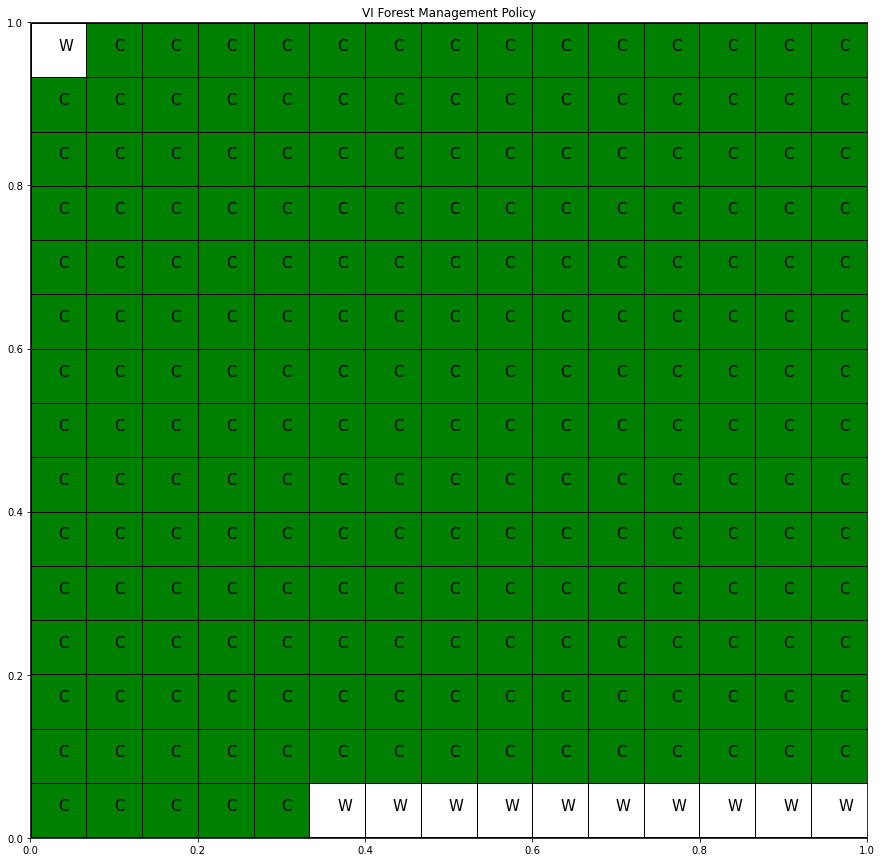

In [234]:
envPlot(15, "VI Forest Management Policy", PI_FM_policy, FM_actions, FM_colorBG, 
        PI_FM_policy, 15)

### plots

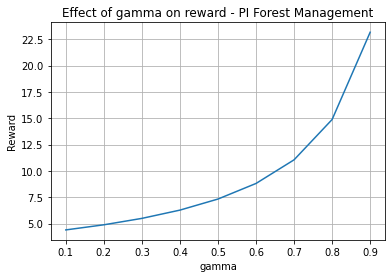

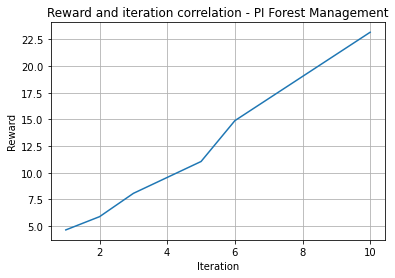

In [382]:
plotMeans(PI_FM_results_df, "gamma", "Reward", 
          "Effect of gamma on reward - PI Forest Management")
plotMeans(PI_FM_results_df, "Iteration", "Reward", 
          "Reward and iteration correlation - PI Forest Management")

<AxesSubplot:title={'center':'Reward and iteration correlation - PI Forest Management'}, xlabel='Iteration', ylabel='Reward'>

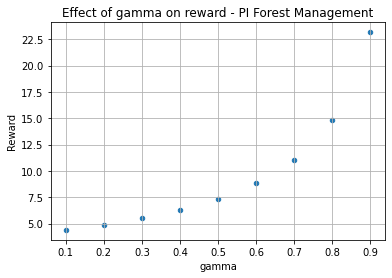

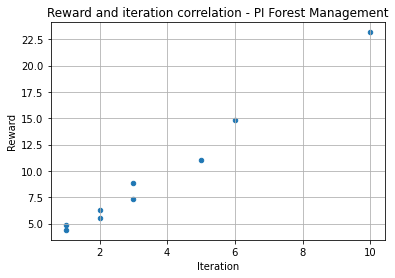

In [352]:
PI_FM_results_df.plot(x="gamma", y="Reward", 
                      title="Effect of gamma on reward - PI Forest Management",
                     kind="scatter", grid=True)

PI_FM_results_df.plot(x="Iteration", y="Reward", 
                      title="Reward and iteration correlation - PI Forest Management",
                     kind="scatter", grid=True)

## Q-learning

In [261]:
%%time
QL_hyperNames = ["gamma", "alpha", "alpha_decay", "epsilon_decay", "n_iter"]
QL_hyperList = [
    [0.9, 0.99],
    [0.1, 0.2],
    [0.9, 0.99],
    [0.9, 0.99],
    [1000000, 10000000]
]

QL_hyperparams = helperIterateHyperParams(QL_hyperNames, QL_hyperList)
QL_FM_results = RL_routine(T_fm, R_fm, QL_hyperparams, QLearning, verbose=True)
QL_FM_results_df = RL_routine_results_to_DF(QL_FM_results)

param combo 1/32
param combo 2/32
param combo 3/32
param combo 4/32
param combo 5/32
param combo 6/32
param combo 7/32
param combo 8/32
param combo 9/32
param combo 10/32
param combo 11/32
param combo 12/32
param combo 13/32
param combo 14/32
param combo 15/32
param combo 16/32
param combo 17/32
param combo 18/32
param combo 19/32
param combo 20/32
param combo 21/32
param combo 22/32
param combo 23/32
param combo 24/32
param combo 25/32
param combo 26/32
param combo 27/32
param combo 28/32
param combo 29/32
param combo 30/32
param combo 31/32
param combo 32/32
CPU times: user 2h 6min 49s, sys: 1min 28s, total: 2h 8min 17s
Wall time: 2h 7min 56s


In [395]:
with open('QL_FM_results.pickle', 'wb') as handle:
    pickle.dump(QL_FM_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

### QL FM results df

In [263]:
QL_FM_results_df

,gamma,alpha,alpha_decay,epsilon_decay,n_iter,Time,Iteration,Reward
0,0.90,0.1,0.90,0.90,1000000,43.514220,1000000,5.022826
1,0.90,0.1,0.90,0.90,10000000,434.370796,10000000,14.924707
2,0.90,0.1,0.90,0.99,1000000,43.557482,1000000,5.032929
3,0.90,0.1,0.90,0.99,10000000,434.459344,10000000,10.059268
4,0.90,0.1,0.99,0.90,1000000,43.606645,1000000,5.027563
5,0.90,0.1,0.99,0.90,10000000,435.362193,10000000,10.595554
6,0.90,0.1,0.99,0.99,1000000,43.761804,1000000,5.030073
7,0.90,0.1,0.99,0.99,10000000,437.347148,10000000,15.196252
8,0.90,0.2,0.90,0.90,1000000,43.726494,1000000,5.031585
9,0.90,0.2,0.90,0.90,10000000,435.645322,10000000,18.195914


In [344]:
QL_FM_results_df['Time'].mean()

239.88938838988543

### plot QL FM policy

In [268]:
QL_FM_policy = np.array(QL_FM_results[QL_FM_results_df['Reward'].argmax()]['policy']).reshape((15, 15))
QL_FM_policy

array([[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0],
       [1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0],
       [0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
       [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1],
       [1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
       [1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1],
       [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1],
       [0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0],
       [0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1],
       [1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1],
       [1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0]])

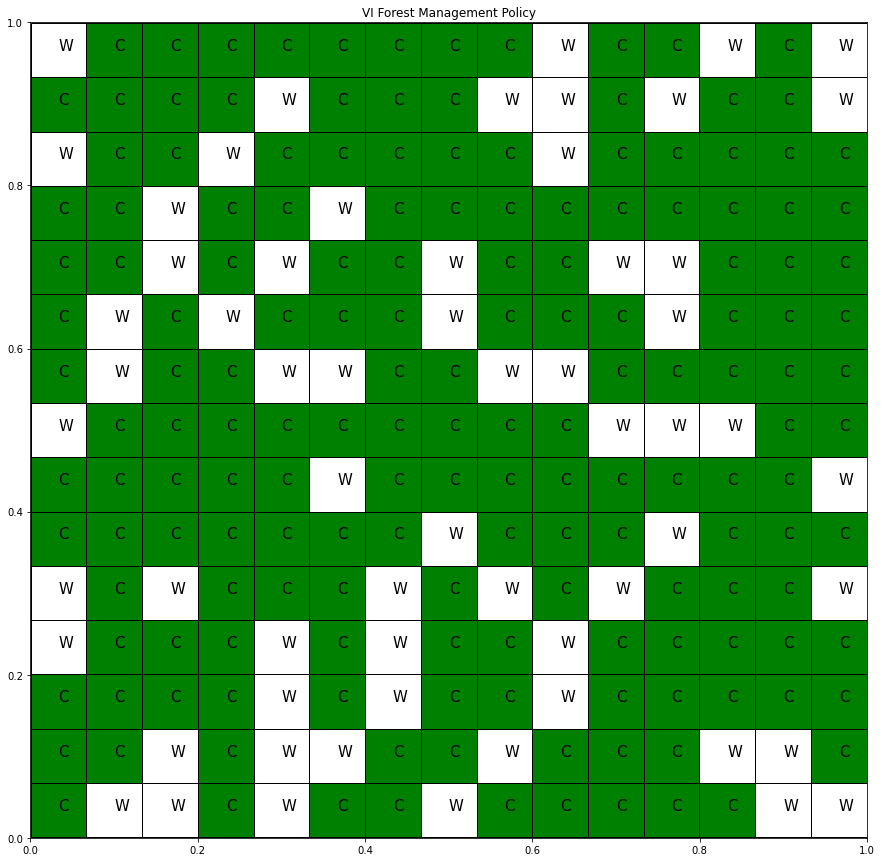

In [269]:
envPlot(15, "VI Forest Management Policy", QL_FM_policy, FM_actions, FM_colorBG, 
        QL_FM_policy, 15)

#### plots

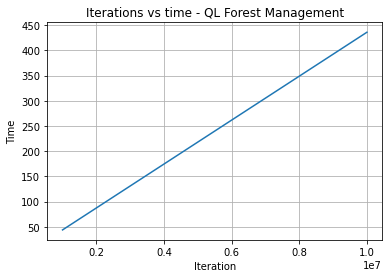

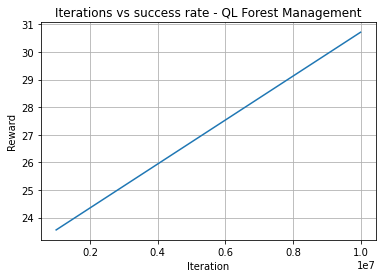

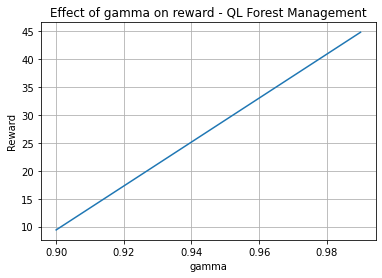

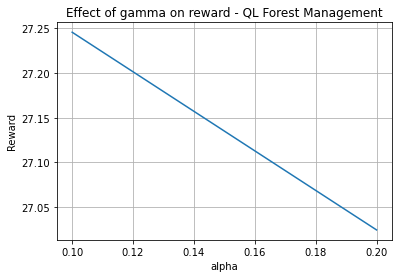

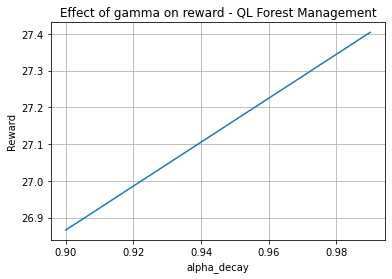

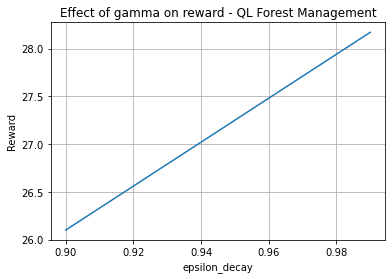

In [385]:
plotMeans(QL_FM_results_df, "Iteration", "Time", 
          "Iterations vs time - QL Forest Management")

plotMeans(QL_FM_results_df, "Iteration", "Reward", 
          "Iterations vs success rate - QL Forest Management")

plotMeans(QL_FM_results_df, "gamma", "Reward", 
          "Effect of gamma on reward - QL Forest Management")

plotMeans(QL_FM_results_df, "alpha", "Reward", 
          "Effect of gamma on reward - QL Forest Management")

plotMeans(QL_FM_results_df, "alpha_decay", "Reward", 
          "Effect of gamma on reward - QL Forest Management")

plotMeans(QL_FM_results_df, "epsilon_decay", "Reward", 
          "Effect of gamma on reward - QL Forest Management")

<AxesSubplot:title={'center':'Effect of epsilon_decay on Reward - QL Forest Management'}, xlabel='epsilon_decay', ylabel='Reward'>

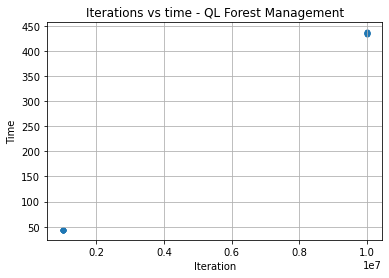

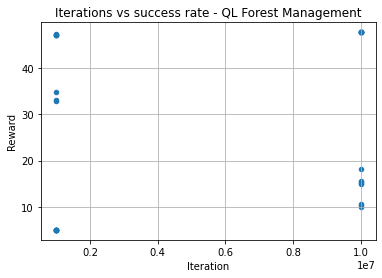

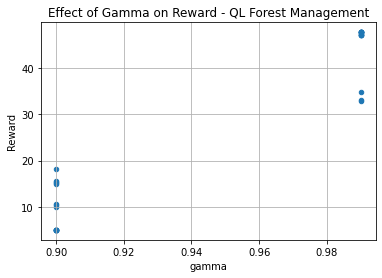

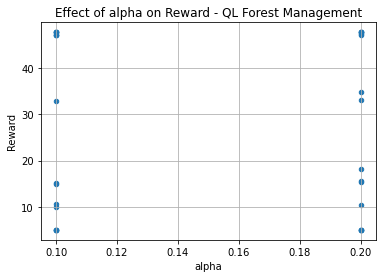

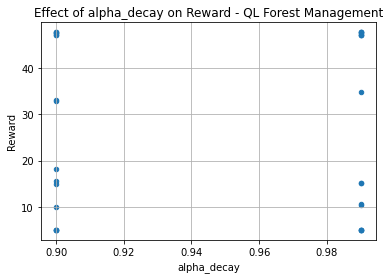

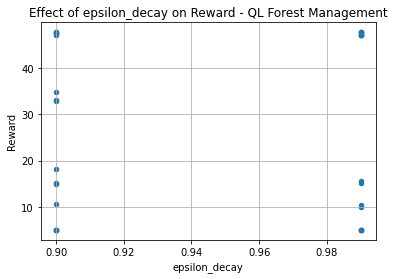

In [383]:
QL_FM_results_df.plot(x="Iteration", y="Time", 
                      kind='scatter', title="Iterations vs time - QL Forest Management", grid=True)

QL_FM_results_df.plot(x="Iteration", y="Reward", kind='scatter', 
                      title="Iterations vs success rate - QL Forest Management", grid=True)

QL_FM_results_df.plot(x="gamma", y="Reward", kind='scatter', 
                      title="Effect of Gamma on Reward - QL Forest Management", grid=True)
QL_FM_results_df.plot(x="alpha", y="Reward", kind='scatter', 
                      title="Effect of alpha on Reward - QL Forest Management", grid=True)
QL_FM_results_df.plot(x="alpha_decay", y="Reward", kind='scatter', 
                      title="Effect of alpha_decay on Reward - QL Forest Management", grid=True)
QL_FM_results_df.plot(x="epsilon_decay", y="Reward", kind='scatter', 
                      title="Effect of epsilon_decay on Reward - QL Forest Management", grid=True)

## END

In [396]:
#!pip freeze > requirements.txt